In [1]:
# from 23B

In [56]:
import csv
# import cv2
import os
# import tensorflow as tf
# import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.layers import Dense, Flatten, Conv2D
# from tensorflow.keras import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator

# python standard libraries
# import os
# from os import path

import random
import fnmatch
import datetime
import pickle

# data processing
import numpy as np
np.set_printoptions(formatter={'float_kind':lambda x: "%.4f" % x})



import pandas as pd
pd.set_option('display.width', 300)
pd.set_option('display.float_format', '{:,.4f}'.format)
pd.set_option('display.max_colwidth', 200)

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.python.keras import regularizers
from tensorflow.keras.models import Sequential  # V2 is tensorflow.keras.xxxx, V1 is keras.xxx
from tensorflow.keras.layers import Conv2D, Concatenate, MaxPool2D, BatchNormalization, Dropout, Flatten, Dense, Input, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model
print( f'tf.__version__: {tf.__version__}' )
print( f'keras.__version__: {keras.__version__}' )

# sklearn
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

# imaging
import cv2
from imgaug import augmenters as img_aug
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image, ImageEnhance


tf.__version__: 2.4.1
keras.__version__: 2.4.0


In [57]:
yy = []
xx = []

with open('train_flip_correct.csv', mode='r') as infile:
    reader = csv.reader(infile)
    next(reader)
#     print(reader)
    with open('training_norm_new.csv', mode='w') as outfile:
        writer = csv.writer(outfile)
#         c = 0
        for rows in reader:
#             if c > 100:
#                 break
            f = rows[0]
            a = float(rows[1])
            s = float(rows[2])
            yy.append(s)
            filename = str(f)
            xx.append(filename)

In [58]:
directory_annotations = '/Users/Kamyab/Documents/UoN/MLiS_2/Project/Redesigned/'
x_names=[]
y=[]
for file in os.listdir(directory_annotations):
    if file == '.DS_Store' or file == '.DS_S.xml':
        continue
    
    if '_' in file:
        f=(file.split('_')[0])
    else:
        f=(file.split('.')[0])
    x_names.append(file)
    y.append(yy[xx.index(f)])

In [59]:
print(np.shape(x_names))

(38860,)


In [60]:
print(np.shape(y))

(38860,)


In [61]:
def image_data_generator(image_paths, steering_angles, batch_size, is_training, shuffle=True):
    num_batches = int(np.floor(len(image_paths) / batch_size))
    bc = 0
#     print('bc ', bc)
    indexes = np.arange(len(image_paths))
    if shuffle == True:
            np.random.shuffle(indexes)
    while True:
        batch_images = []
        batch_steering_angles = []
        path = '/Users/Kamyab/Documents/UoN/MLiS_2/Project/Redesigned/'
       
        for i in range(batch_size):
            index = bc * batch_size + i  
#             print('bc, i, index, indexes, is_training = ', bc, i, index, indexes[index], is_training)
            image_path = path + image_paths[indexes[index]]
            image = cv2.imread(image_path)
            steering_angle = steering_angles[indexes[index]]
#             if is_training:
#                 # training: augment image
#                 image, steering_angle = random_augment(image, steering_angle)
             
            image = img_preprocess(image)
            batch_images.append(image)
            batch_steering_angles.append(steering_angle)
        bc += 1 
        if bc >= num_batches:
            bc = 0
            if shuffle == True:
                np.random.shuffle(indexes)        
        yield( np.asarray(batch_images), np.asarray(batch_steering_angles))

In [62]:
X_train, X_valid, y_train, y_valid = train_test_split( x_names, y, test_size=0.2)
print("Training data: %d\nValidation data: %d" % (len(X_train), len(X_valid)))

Training data: 31088
Validation data: 7772


In [63]:
def zoom(image):
    zoom = img_aug.Affine(scale=(1, 1.3))  # zoom from 100% (no zoom) to 130%
    image = zoom.augment_image(image)
    return image

In [64]:
def pan(image):
    # pan left / right / up / down about 10%
    pan = img_aug.Affine(translate_percent= {"x" : (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan.augment_image(image)
    return image

In [65]:
def adjust_brightness(image):
    # increase or decrease brightness by 30%
    brightness = img_aug.Multiply((0.7, 1.3))
    image = brightness.augment_image(image)
    return image

In [66]:
def blur(image):
    kernel_size = random.randint(1, 5)  # kernel larger than 5 would make the image way too blurry
    image = cv2.blur(image,(kernel_size, kernel_size))
   
    return image

In [67]:
def random_flip(image, steering_angle):
#     is_flip = random.randint(0, 1)
#     if is_flip == 1:
        # randomly flip horizon
    image = cv2.flip(image,1)
#     steering_angle = 1 - steering_angle
#         steering_angle = (80 - steering_angle*80)/80
        #(180 - (steering_angle[0]*80 + 50) -50)/80
   
    return image, steering_angle


In [68]:
def random_augment(image, steering_angle):
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
#     if np.random.rand() < 0.5:
#         image = blur(image)
#     if np.random.rand() < 0.5:
#         image = adjust_brightness(image)
    if np.random.rand() < 0.75:
        image, steering_angle = random_flip(image, steering_angle)
    
    return image, steering_angle



# show a few randomly augmented images
# ncol = 2
# nrow = 10
# fig, axes = plt.subplots(nrow, ncol, figsize=(15, 50))

# for i in range(nrow):
#     rand_index = random.randint(0, len(image_paths) - 1)
#     image_path = image_paths[rand_index]
#     steering_angle_orig = steering_angles[rand_index]
    
#     image_orig = my_imread(image_path)
#     image_aug, steering_angle_aug = random_augment(image_orig, steering_angle_orig)
    
#     axes[i][0].imshow(image_orig)
#     axes[i][0].set_title("original, angle=%s" % steering_angle_orig)
#     axes[i][1].imshow(image_aug)
#     axes[i][1].set_title("augmented, angle=%s" % steering_angle_aug)
    

In [69]:
def img_preprocess(image):
    height, _, _ = image.shape
#     image = image[int(height/2):,:,:]
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)  # Nvidia model said it is best to use YUV color space
#     image = cv2.GaussianBlur(image, (3,3), 0)
    image = cv2.resize(image, (160,120)) # input image size (200,66) Nvidia model
#     image[85:,:] = 255 - image[85:,:]
    image = image / 255 # normalizing
    return image

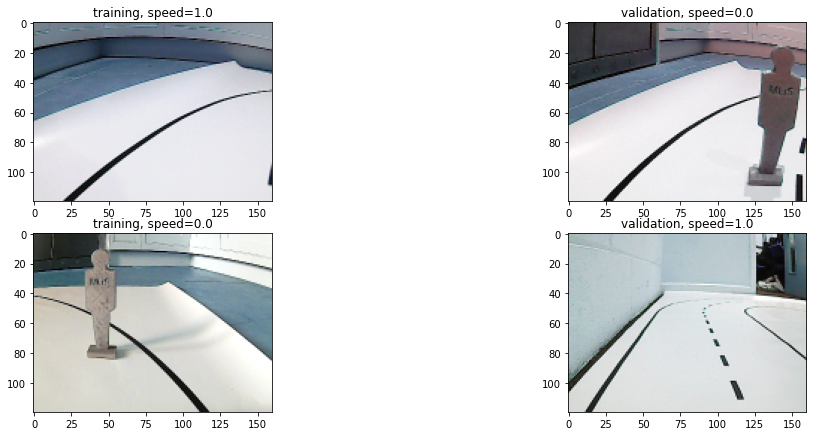

In [70]:
ncol = 2
nrow = 2

X_train_batch, y_train_batch = next(image_data_generator(X_train, y_train, nrow, True))
X_valid_batch, y_valid_batch = next(image_data_generator(X_valid, y_valid, nrow, False))

fig, axes = plt.subplots(nrow, ncol, figsize=(15, 6))
fig.tight_layout()

for i in range(nrow):
    axes[i][0].imshow(X_train_batch[i])
    axes[i][0].set_title("training, speed=%s" % y_train_batch[i])
    axes[i][1].imshow(X_valid_batch[i])
    axes[i][1].set_title("validation, speed=%s" % y_valid_batch[i])

In [71]:
print(np.shape(X_train_batch[0]))

(120, 160, 3)


In [72]:
inp1 = Input(shape=(120, 160, 3))

x = Conv2D(32, (5, 5), strides=(2, 2), activation='elu')(inp1)
x = Conv2D(32, (5, 5), strides=(2, 2), activation='elu')(x)
# x = MaxPooling2D(pool_size=(3, 3),strides=2)(x)
# x2 = Dropout(0.2)(x2)
x = Conv2D(48, (5, 5), activation='elu')(x)
x = Conv2D(48, (5, 5), activation='elu')(x)
x = MaxPooling2D(pool_size=(2, 2),strides=2)(x)

x = Conv2D(64, (3, 3), activation='elu')(x)
x = Conv2D(64, (3, 3), activation='elu')(x)
x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2),strides=2)(x)
# x = Dropout(0.3)(x)
x = Flatten()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='elu')(x)
x = Dense(100, activation='elu')(x)
x = BatchNormalization()(x)

x1 = Dense(50, activation='elu')(x)
x1 = Dense(10, activation='elu')(x1)
# x = BatchNormalization()(x)
out = Dense(1, activation='sigmoid', name='speed')(x1) 


model = keras.Model(inputs=[inp1], outputs=out)
model.summary()
# loss_weights = [0.9, 0.1]
optimizer = Adam(lr=1e-3) # lr is learning rate
model.compile(loss='binary_crossentropy', optimizer=optimizer)#, loss_weights = loss_weights )

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 120, 160, 3)]     0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 58, 78, 32)        2432      
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 27, 37, 32)        25632     
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 23, 33, 48)        38448     
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 19, 29, 48)        57648     
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 9, 14, 48)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 7, 12, 64)         2771

In [73]:
batch_size = 32
train_steps = int(np.floor(len(X_train) / batch_size))
valid_steps = int(np.floor(len(X_valid) / batch_size))
print(train_steps, valid_steps)

971 242


In [74]:
# saves the model weights after each epoch if the validation loss decreased
model_output_dir = '/Users/Kamyab/Documents/UoN/MLiS_2/Project/All models/NoTLspeed/'

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(model_output_dir,'Speed_NoTL{epoch:04d}.h5'), verbose=1, save_best_only=True)

history = model.fit_generator(image_data_generator( X_train, y_train, batch_size=batch_size, is_training=True),
                              steps_per_epoch=train_steps,
                              epochs=50,
                              validation_data = image_data_generator( X_valid, y_valid, batch_size=100, is_training=False),
                              validation_steps=valid_steps, 
                              verbose=1,
                              shuffle=1,
                              callbacks=[checkpoint_callback])
# always save model output as soon as model finishes training
model.save(os.path.join(model_output_dir,'Speed_NoTL_model.h5'))

Epoch 1/50
971/971 [==============================] - 643s 662ms/step - loss: 0.3998 - val_loss: 0.5054

Epoch 00001: val_loss improved from inf to 0.50536, saving model to /Users/Kamyab/Documents/UoN/MLiS_2/Project/All models/NoTLspeed/Speed_NoTL0001.h5
Epoch 2/50
971/971 [==============================] - 659s 679ms/step - loss: 0.2374 - val_loss: 0.2301

Epoch 00002: val_loss improved from 0.50536 to 0.23011, saving model to /Users/Kamyab/Documents/UoN/MLiS_2/Project/All models/NoTLspeed/Speed_NoTL0002.h5
Epoch 3/50
971/971 [==============================] - 661s 681ms/step - loss: 0.1987 - val_loss: 0.1727

Epoch 00003: val_loss improved from 0.23011 to 0.17272, saving model to /Users/Kamyab/Documents/UoN/MLiS_2/Project/All models/NoTLspeed/Speed_NoTL0003.h5
Epoch 4/50
971/971 [==============================] - 659s 679ms/step - loss: 0.1520 - val_loss: 0.3200

Epoch 00004: val_loss did not improve from 0.17272
Epoch 5/50
971/971 [==============================] - 660s 680ms/step -

dict_keys(['loss', 'val_loss'])


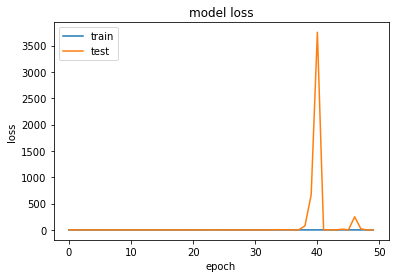

In [75]:
df = pd.DataFrame(history.history)
print(history.history.keys())
# # summarize history for accuracy
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
# plt.title('model accuracy')
# plt.ylabel('accuracy')
# plt.xlabel('epoch')
# plt.legend(['train', 'test'], loc='upper left')
# plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [42]:
model_output_dir = '/Users/Kamyab/Documents/UoN/MLiS_2/Project/All models/NoTLspeed/'
from sklearn.metrics import mean_squared_error, r2_score

def summarize_prediction(Y_true, Y_pred):
    
    mse = mean_squared_error(Y_true, Y_pred)
    r_squared = r2_score(Y_true, Y_pred)
    
    
    print(f'mse       = {mse:.2}')
    print(f'r_squared = {r_squared:.2%}')
    print()
    
def predict_and_summarize(X, Y):
    model = load_model(f'{model_output_dir}/Speed_NoTL_model.h5')
    Y_pred = model.predict(X)
#     summarize_prediction(Y, Y_pred)
    return Y_pred

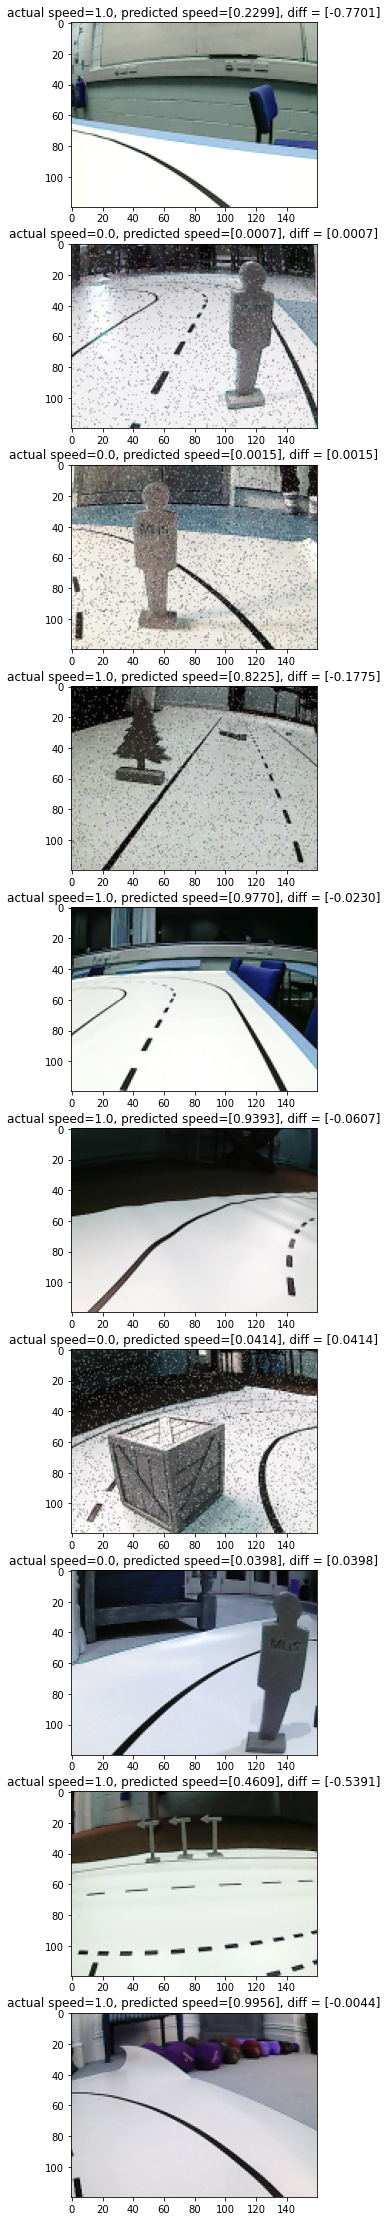

In [44]:
n_tests = 100
X_test, y_test = next(image_data_generator(X_valid, y_valid, 100, False))

y_pred = predict_and_summarize(X_test, y_test)

n_tests_show = 10
fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
for i in range(n_tests_show):
    axes[i].imshow(X_test[i])
    axes[i].set_title(f"actual speed={y_test[i]}, predicted speed={(y_pred[i])}, diff = {(y_pred[i])-y_test[i]}")
    

In [45]:
model = load_model(f'{model_output_dir}/Speed_NoTL_model.h5')
path_file = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Data/test_data/test_data/'
test_names = np.arange(1020) + 1
# with open(path_file + 'submission2.csv', mode='w', newline='') as submission:
#     writer = csv.writer(submission, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
#     writer.writerow(['image_id', 'angle', 'speed'])
# for name in test_names[3]:     
img = cv2.imread(path_file + str(test_names[328]) + '.png')
#         print(img)
prediction = compute_steering_angle(model, img)
        
print(prediction)
plt.imshow(img)
   
 

NameError: name 'compute_steering_angle' is not defined

In [46]:
model_output_dir = '/Users/Kamyab/Documents/UoN/MLiS_2/Project/All models/NoTLspeed/'
model = load_model(os.path.join(model_output_dir,'Speed_NoTL_model.h5'))
       
def compute_steering_angle(self, frame):
    preprocessed = img_preprocess(frame)
    X = np.asarray([preprocessed])
    steering_angle = model.predict(X)
    return steering_angle

0.9817979


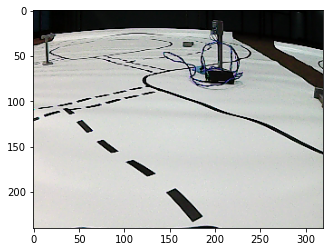

In [55]:
path_file = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Data/test_data/test_data/'
img = cv2.imread(path_file + str(1020)+'.png')
print(compute_steering_angle(model, img)[0][0])
plt.imshow(img)

In [48]:
path_file = '/Users/kamyab/Documents/UoN/MLiS_2/Project/Data/test_data/test_data/'

test_names = np.arange(1020) + 1
with open(path_file + 'speed2May.csv', mode='w', newline='') as submission:
    writer = csv.writer(submission, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(['image_id', 'speed'])
 
#     fig, axes = plt.subplots(n_tests_show, 1, figsize=(10, 4 * n_tests_show))
    for name in test_names:     
        img = cv2.imread(path_file + str(name) + '.png')
        prediction = compute_steering_angle(model, img)
        
#         if prediction[0][0] > 0.5:
#             speed = 1
#         else:
#             speed = 0    
#         writer.writerow([name, prediction])
        print('{0},{1:0.2f}'.format(name, prediction[0][0]))

 

1,0.00
2,0.95
3,0.71
4,0.84
5,0.86
6,0.83
7,0.91
8,0.94
9,0.00
10,0.75
11,0.00
12,0.00
13,0.99
14,0.00
15,0.98
16,0.44
17,0.00
18,0.01
19,0.00
20,0.98
21,0.98
22,0.85
23,0.87
24,0.00
25,0.02
26,0.96
27,0.00
28,0.00
29,0.00
30,0.99
31,0.92
32,0.90
33,0.00
34,1.00
35,0.00
36,0.92
37,0.97
38,0.90
39,0.00
40,0.96
41,0.94
42,0.00
43,0.91
44,0.05
45,1.00
46,0.00
47,0.00
48,0.02
49,0.87
50,0.21
51,0.86
52,0.53
53,0.00
54,0.73
55,0.00
56,0.00
57,0.00
58,0.00
59,0.81
60,0.99
61,0.00
62,0.96
63,0.88
64,0.00
65,0.52
66,0.00
67,0.00
68,0.00
69,0.93
70,0.00
71,0.99
72,0.00
73,0.00
74,0.49
75,0.10
76,0.98
77,0.94
78,0.91
79,1.00
80,0.81
81,0.88
82,0.98
83,0.12
84,0.33
85,0.96
86,0.10
87,0.99
88,0.40
89,0.15
90,0.89
91,0.89
92,0.88
93,0.02
94,0.99
95,0.00
96,0.00
97,0.88
98,0.00
99,0.67
100,0.95
101,0.01
102,0.87
103,0.90
104,0.18
105,0.58
106,0.00
107,0.01
108,1.00
109,0.98
110,0.00
111,0.95
112,0.00
113,0.00
114,0.00
115,0.02
116,0.94
117,0.01
118,0.95
119,0.81
120,0.00
121,0.89
122,0.01
123,0.10
1